<a href="https://colab.research.google.com/github/tmrb/Master-project-codes/blob/main/Film_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import sys
try:
  drive.mount("/content/drive", force_remount=True)
  root  = '/content/drive/My Drive'
  sys.path.append(root)
except:
  print('erro encontrado')

Mounted at /content/drive


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Filmes/filmes.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/content/drive/MyDrive/Filmes/filmes_2'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_approved_dir = os.path.join(train_dir, 'approved')

# Directory with our training dog pictures
train_disapproved_dir = os.path.join(train_dir, 'disapproved')

# Directory with our validation cat pictures
validation_approved_dir = os.path.join(validation_dir, 'approved')

# Directory with our validation dog pictures
validation_disapproved_dir = os.path.join(validation_dir, 'disapproved')

In [ ]:
train_approved_fnames = os.listdir(train_approved_dir)
print(train_approved_fnames[:10])

train_disapproved_fnames = os.listdir(train_disapproved_dir)
train_disapproved_fnames.sort()
print(train_disapproved_fnames[:10])

['example_2.png', 'example_3.png', 'example_0.png', 'example_4.png', 'example_5.png', 'example_6.png', 'example_7.png', 'example_8.png', 'example_9.png', 'example_10.png']
['Cópia de Cópia de Cópia de example_123.png', 'Cópia de Cópia de Cópia de example_32.png', 'Cópia de Cópia de example_1 (1).png', 'Cópia de Cópia de example_1.png', 'Cópia de Cópia de example_101 (1).png', 'Cópia de Cópia de example_101.png', 'Cópia de Cópia de example_102 (1).png', 'Cópia de Cópia de example_102.png', 'Cópia de Cópia de example_103 (1).png', 'Cópia de Cópia de example_103.png']


In [ ]:
print('total training approved images:', len(os.listdir(train_approved_dir)))
print('total training disapproved images:', len(os.listdir(train_disapproved_dir)))
print('total validation approved images:', len(os.listdir(validation_approved_dir)))
print('total validation disapproved images:', len(os.listdir(validation_disapproved_dir)))

total training approved images: 124
total training disapproved images: 74
total validation approved images: 15
total validation disapproved images: 6


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

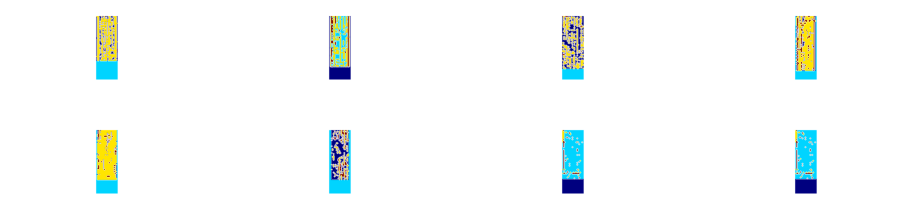

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 2)

pic_index += 4
next_approved_pix = [os.path.join(train_approved_dir, fname) 
                for fname in train_approved_fnames[pic_index-4:pic_index]]
next_disapproved_pix = [os.path.join(train_disapproved_dir, fname) 
                for fname in train_disapproved_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_approved_pix+next_disapproved_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)  
  sp.set_axis_off()
  img = mpimg.imread(img_path)
  plt.imshow(img)
  
plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers

In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window

x = layers.Conv2D(3, 2, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
#x = layers.Dropout(0.5)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(8, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu',kernel_regularizer=regularizers.l1(1e-4), bias_regularizer=regularizers.l2(1e-5))(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.5)(x)

In [ ]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 149, 149, 3)       39        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 8)         224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 16)        0     

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150,150),
        batch_size = 3,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        batch_size=3,
        target_size=(150,150), 
        class_mode='binary')

Found 198 images belonging to 2 classes.
Found 21 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator, # 2000 images = batch_size * steps
      steps_per_epoch = 2,
      epochs=25,
      validation_data=validation_generator,
      validation_steps=5,  # 1000 images = batch_size * steps
      verbose=2, class_weight={0:0.7,1:0.3})

Epoch 1/25
2/2 - 8s - loss: 0.4912 - acc: 0.3333 - val_loss: 0.7981 - val_acc: 0.8000
Epoch 2/25
2/2 - 2s - loss: 0.2960 - acc: 0.8333 - val_loss: 0.7936 - val_acc: 0.7333
Epoch 3/25
2/2 - 2s - loss: 0.2107 - acc: 0.6667 - val_loss: 0.5085 - val_acc: 0.8000
Epoch 4/25
2/2 - 1s - loss: 0.3564 - acc: 0.5000 - val_loss: 0.6831 - val_acc: 0.6667
Epoch 5/25
2/2 - 2s - loss: 0.1877 - acc: 0.8333 - val_loss: 0.8927 - val_acc: 0.7333
Epoch 6/25
2/2 - 1s - loss: 0.2410 - acc: 0.8333 - val_loss: 1.3786 - val_acc: 0.6000
Epoch 7/25
2/2 - 1s - loss: 0.3102 - acc: 0.6667 - val_loss: 0.6247 - val_acc: 0.7333
Epoch 8/25
2/2 - 1s - loss: 0.2896 - acc: 0.5000 - val_loss: 0.7597 - val_acc: 0.6000
Epoch 9/25
2/2 - 1s - loss: 0.2999 - acc: 0.6667 - val_loss: 0.4485 - val_acc: 0.8667
Epoch 10/25
2/2 - 1s - loss: 0.1847 - acc: 1.0000 - val_loss: 0.9415 - val_acc: 0.7333
Epoch 11/25
2/2 - 1s - loss: 0.3385 - acc: 0.6667 - val_loss: 0.6495 - val_acc: 0.7333
Epoch 12/25
2/2 - 1s - loss: 0.2497 - acc: 0.8333 - 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


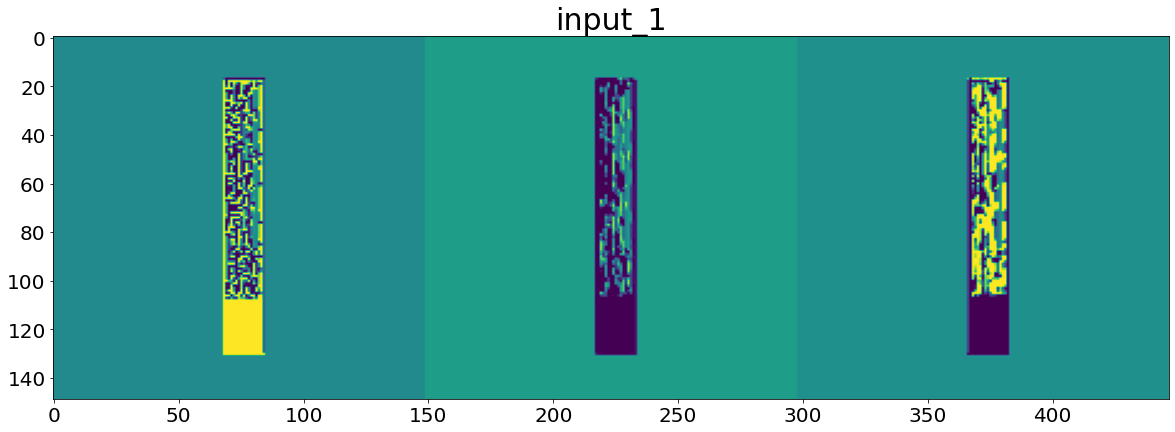

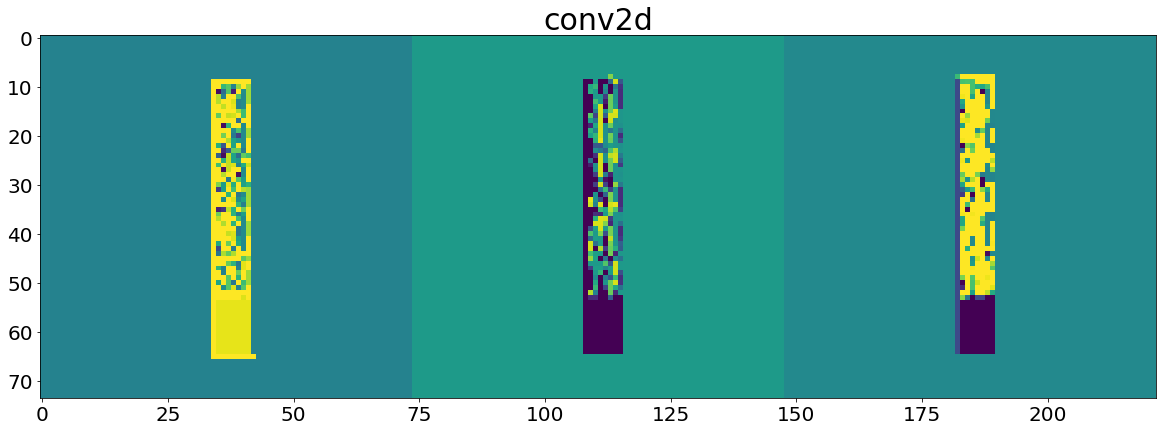

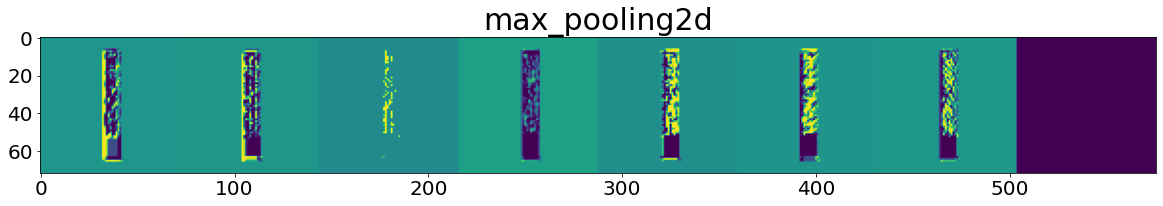

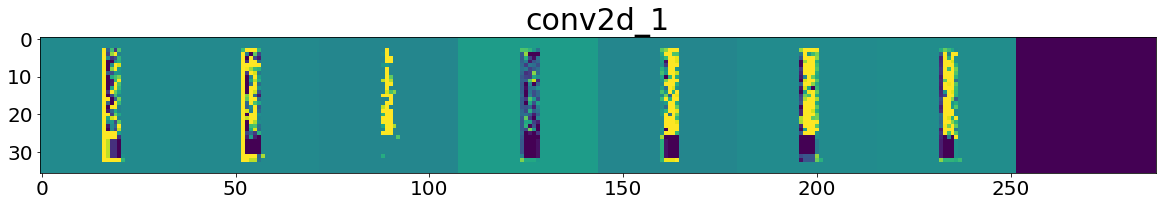

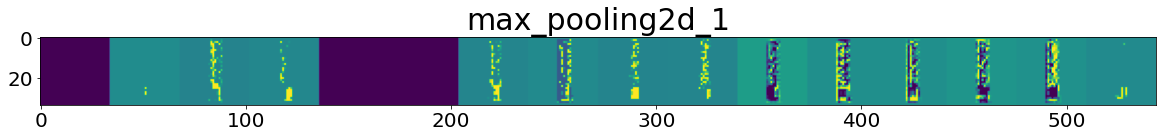

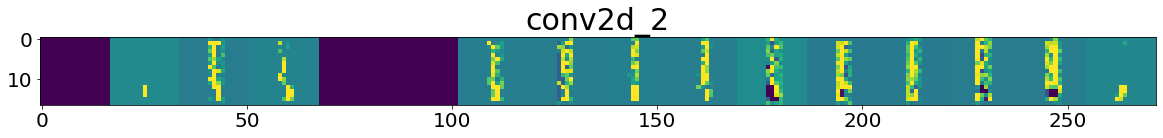

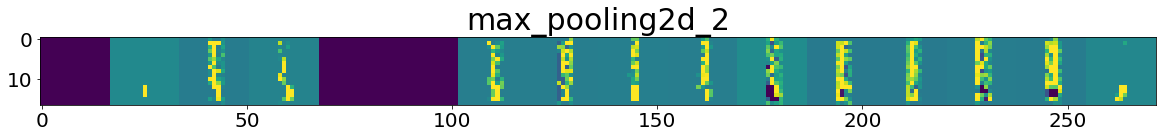

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
approved_img_files = [os.path.join(train_approved_dir, f) for f in train_approved_fnames]
disapproved_img_files = [os.path.join(train_disapproved_dir, f) for f in train_disapproved_fnames]
#img_path = random.choice(approved_img_files + disapproved_img_files)
img_path = '/content/drive/MyDrive/Filmes/filmes_2/train/disapproved/Cópia de example_31.png'

img = load_img(img_path, target_size=(150,150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.yticks(fontsize=20)
    plt.xticks(fontsize= 20)
    plt.title(layer_name,fontsize=30)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    #plt.savefig('/content/drive/MyDrive/Filmes/Rede_teste_normal_{}.png'.format(layer_name), dpi = 600)

Text(0.5, 1.0, 'Training and validation loss')

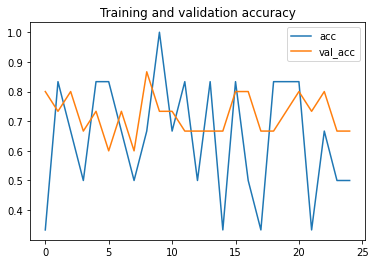

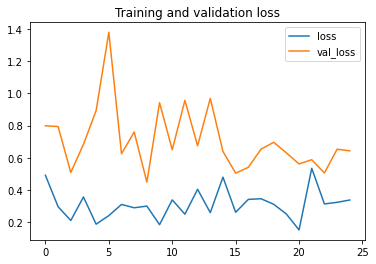

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.legend(['acc','val_acc'])
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(['loss','val_loss'])
plt.title('Training and validation loss')

In [ ]:
history.history

{'acc': [0.3333333432674408,
  0.8333333134651184,
  0.6666666865348816,
  0.5,
  0.8333333134651184,
  0.8333333134651184,
  0.6666666865348816,
  0.5,
  0.6666666865348816,
  1.0,
  0.6666666865348816,
  0.8333333134651184,
  0.5,
  0.8333333134651184,
  0.3333333432674408,
  0.8333333134651184,
  0.5,
  0.3333333432674408,
  0.8333333134651184,
  0.8333333134651184,
  0.8333333134651184,
  0.3333333432674408,
  0.6666666865348816,
  0.5,
  0.5],
 'loss': [0.49119099974632263,
  0.2959825098514557,
  0.21070127189159393,
  0.35640326142311096,
  0.18766950070858002,
  0.2409532517194748,
  0.3102331757545471,
  0.28956708312034607,
  0.2999057471752167,
  0.18465964496135712,
  0.33850109577178955,
  0.24973614513874054,
  0.4042719304561615,
  0.25941410660743713,
  0.47940412163734436,
  0.2615906894207001,
  0.34156250953674316,
  0.34564408659935,
  0.31125131249427795,
  0.2507147490978241,
  0.15215978026390076,
  0.5343217253684998,
  0.3132759630680084,
  0.3233858346939087,


In [ ]:
normal = {'val_acc': [0.7333333492279053,
0.7333333492279053,
0.7333333492279053,
0.6000000238418579,
0.6666666865348816,
0.7333333492279053,
0.6666666865348816,
0.6666666865348816,
0.7333333492279053,
0.6666666865348816,
0.7333333492279053,
0.800000011920929,
0.6666666865348816,
0.7333333492279053,
0.6666666865348816,
0.6666666865348816,
0.800000011920929,
0.7333333492279053,
0.800000011920929,
0.7333333492279053,
0.7333333492279053,
0.7333333492279053,
0.7333333492279053,
0.6666666865348816,
0.7333333492279053],
'val_loss': [0.6397837400436401,
0.5855153203010559,
0.6004947423934937,
0.6995221972465515,
0.6373454928398132,
0.5976309180259705,
0.6475719809532166,
0.7401588559150696,
0.6207339763641357,
0.662463903427124,
0.5828425884246826,
0.5059159398078918,
0.6541891694068909,
0.6073259711265564,
0.6797770857810974,
0.6433213353157043,
0.5129051804542542,
0.5897321105003357,
0.5150303244590759,
0.5877332091331482,
0.5837848782539368,
0.594396710395813,
0.5949310660362244,
0.6504409909248352,
0.6029996871948242]}

segmented = {'val_acc': [0.800000011920929,
0.800000011920929,
0.6000000238418579,
0.800000011920929,
0.6000000238418579,
0.7333333492279053,
0.6666666865348816,
0.7333333492279053,
0.7333333492279053,
0.7333333492279053,
0.6666666865348816,
0.6666666865348816,
0.7333333492279053,
0.6666666865348816,
0.6666666865348816,
0.6666666865348816,
0.6666666865348816,
0.7333333492279053,
0.6000000238418579,
0.7333333492279053,
0.8666666746139526,
0.8666666746139526,
0.800000011920929,
0.6666666865348816,
0.6666666865348816],
'val_loss': [0.8514154553413391,
0.5117566585540771,
0.7180059552192688,
0.52105313539505,
0.8316580653190613,
0.5826619863510132,
0.6791468262672424,
0.6182475686073303,
0.5846618413925171,
0.5951945781707764,
0.7026931643486023,
0.7064187526702881,
0.5739142298698425,
0.6978680491447449,
0.8410364389419556,
0.8970472812652588,
0.8485404849052429,
0.5742754340171814,
0.8828184604644775,
0.7899633049964905,
0.40699002146720886,
0.413573294878006,
0.49914583563804626,
0.7476605772972107,
0.6372304558753967]}
